In [1]:
# libraries we will use
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg
# sns set activates a nicer display for seaborn graphs
sns.set()

In [2]:
# Load data
df1 = pd.read_csv(r'Data/16Hybrids_3yearsRaw.csv')
df_lidar = pd.read_csv(r'Data/HIPS2020_Height_PC.csv')
df3 = pd.read_csv(r'Data/HIPS2020_Reflectance.csv')
df4 = pd.read_csv(r'Data/MSU2020_LeafNutrient.csv')
df_pc = pd.read_csv(r'Data/HIPS2020_Ht_RGB.csv')

In [3]:
# Prepare data
dfs = [df1, df_lidar, df3, df4, df_pc]
for df in dfs:
    df['Plot'] = df['Plot'].astype('str')

df1.rename(columns={'AdjustedYield15.5': 'Yield'}, inplace=True)

df4.rename(columns={'N(%)': 'LeafN'}, inplace=True)

df_field = df1[df1['Year'] == 2020]

df_ref = df3[df3['Band'].isin(['Red', 'NIR', 'SAVIMASK'])]
df_ref = df_ref.loc[:, ['ID', 'Plot', 'MEAN', 'STD', 'Date', 'Band']]

# Calculate NDVI
unmelt = df_ref.pivot(index='ID', columns = 'Band', values= 'MEAN').reset_index()
unmelt['ndvi'] = (unmelt['NIR'] - unmelt['Red']) / (unmelt['NIR'] + unmelt['Red'])
# To split a string into 2 new columns have to limit split to 1 split and set expand = T parameter. 
unmelt[['Plot', 'GDD']] = unmelt['ID'].str.split(pat = '_',n = 1, expand = True)
unmelt['GDD'] = unmelt['GDD'].astype('int')
df_m = pd.merge(unmelt, df_field, on = 'Plot')

# Create a df df_pcmn - point cloud, merged nutrients that contains All data 
meta = list(df_field.columns)
meta.append('GDD')
df_refm = pd.merge(df_field, unmelt, on = 'Plot', how = 'inner')
df_pcm = pd.merge(df_field, df_pc, on = 'Plot', how = 'inner')
df_li = pd.merge(df_field, df_lidar, on = 'Plot', how = 'inner')
df4x = df4.loc[:, ['Plot', 'GDD', 'LeafN']]
df_nm = pd.merge(df_field, df4x, on= 'Plot', how = 'inner')

df_npcr = pd.merge(df_refm, df_pcm, on = meta, how = 'outer')
df_npcr = pd.merge(df_npcr, df_nm, on = meta, how = 'outer')

df_nlir = pd.merge(df_refm, df_li, on = meta, how = 'outer')
df_nlir = pd.merge(df_nlir, df_nm, on = meta, how = 'outer')


# Field_RS_LeafNutrition.csv
# df_npcr.to_clipboard()

# Create a copy which is just of the 5 Hybrids ( B73 x [Mo17, PHZ51, or PHN82], LH195 x PHN82, PHB47 x PHN82 )
df_5hyb_pc = df_npcr[df_npcr['5HybridCode'] == 1]
# 5 hyb lidar
df_5hyb_li = df_nlir[df_nlir['5HybridCode'] == 1]


# Part 1: Remote sensing phenotypes sensitive to N treatment
* Ht, ndvi, and std dev curves across time, select corr plots from combined, H and L, maybe corr over time

c:\Users\bdub\AppData\Local\Programs\Python\Python311\Lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


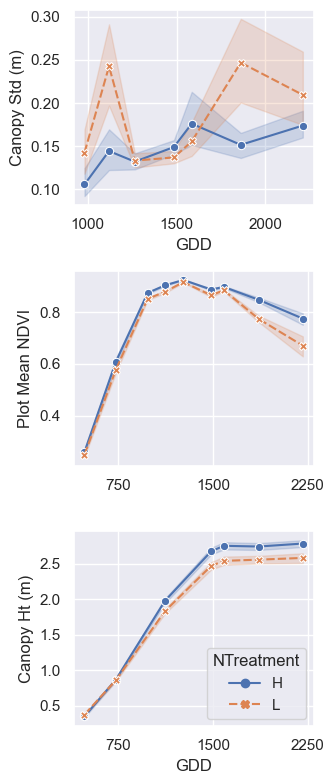

In [4]:
fig, ax = plt.subplots(3, figsize = (3.5,8))
sns.lineplot(ax = ax[0], data = df_npcr[df_npcr['GDD'] > 900], x = 'GDD', y = 'STD', hue = 'NTreatment', style = 'NTreatment', markers=True, legend=False)
ax[0].set_ylabel('Canopy Std (m)')
sns.lineplot(ax = ax[1], data = df_npcr[df_npcr['GDD'] > 450], x = 'GDD', y ='ndvi', hue = 'NTreatment',  style = 'NTreatment', markers=True, legend=False)
ax[1].set_xlabel(None)
ax[1].set_xticks([750, 1500, 2250])
ax[1].set_ylabel('Plot Mean NDVI')
sns.lineplot(ax = ax[2], data = df_nlir[df_nlir['GDD'] > 450], x = 'GDD', y ='PCT90', hue = 'NTreatment',  style = 'NTreatment', markers=True)
ax[2].set_ylabel('Canopy Ht (m)')
ax[2].set_xticks([750, 1500, 2250])
plt.tight_layout()
#plt.savefig('NresponsivePanel.pdf')

In [5]:
# ANOVA to annotate above plot of STD dev
tps = list(df_npcr['GDD'].value_counts().keys())
for tp in tps:
    print(tp)
    df_tp = df_npcr[df_npcr['GDD'] == tp]
    try:
        an1 = pg.anova(data = df_tp, dv = 'STD', between = ['NTreatment', 'Hybrid'])
        print(an1)
    except: 
        print('Failed ANOVA')
        continue

1120
                Source        SS  DF        MS          F     p-unc       np2
0           NTreatment  0.153901   1  0.153901  15.272128  0.000453  0.323068
1               Hybrid  0.251344  15  0.016756   1.662783  0.111282  0.438022
2  NTreatment * Hybrid  0.178581  15  0.011905   1.181418  0.333683  0.356412
3             Residual  0.322471  32  0.010077        NaN       NaN       NaN
1265
                Source        SS  DF        MS         F     p-unc       np2
0           NTreatment  0.000024   1  0.000024  0.042272  0.838404  0.001319
1               Hybrid  0.012695  15  0.000846  1.479390  0.171778  0.409494
2  NTreatment * Hybrid  0.010309  15  0.000687  1.201338  0.319943  0.360257
3             Residual  0.018307  32  0.000572       NaN       NaN       NaN
1485
                Source        SS  DF        MS         F     p-unc       np2
0           NTreatment  0.002319   1  0.002319  7.299858  0.010938  0.185748
1               Hybrid  0.015744  15  0.001050  3.304477

In [6]:
# Create a line graph of the corr of PCT90, STD, and ndvi with yield over time
tps = [982, 1120, 1265, 1485, 1585, 1861, 2210]
df = pd.DataFrame()
for tp in tps:
    print(tp)
    df_tp = df_npcr[df_npcr['GDD'] == tp]
    corr_tp_H = df_tp.loc[df_tp['NTreatment'] == 'H', ['Yield', 'PCT90','STD', 'ndvi']]
    corr_tp_H = corr_tp_H.corr().round(2)
    corr_tp_H = corr_tp_H.iloc[[0],:]
    corr_tp_H['GDD'] = tp
    corr_tp_H['NTreatment'] = 'H'
    corr_tp_L = df_tp.loc[df_tp['NTreatment'] == 'L', ['Yield', 'PCT90','STD', 'ndvi']]
    corr_tp_L = corr_tp_L.corr().round(2)
    corr_tp_L = corr_tp_L.iloc[[0],:]
    corr_tp_L['GDD'] = tp
    corr_tp_L['NTreatment'] = 'L'
    df = pd.concat([df, corr_tp_H])
    df = pd.concat([df, corr_tp_L])

# clean df
df = df.iloc[:, 1:]
df = pd.melt(df, id_vars=['GDD', 'NTreatment'], value_vars=['PCT90', 'ndvi', 'STD'], var_name='Trait', value_name='CorrToYield')

982
1120
1265
1485
1585
1861
2210


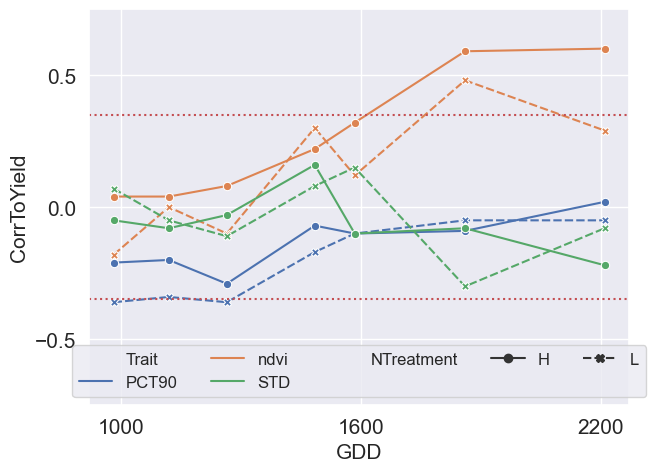

In [7]:
# make plot with new corr df over time
sns.lineplot(data = df, x = 'GDD', y='CorrToYield', hue = 'Trait', style='NTreatment', markers=True)
# critical value for 32 -2 = 30 df = 0.349 and alpha 0.05
plt.axhline(0.349, color = 'r', linestyle = ':')
plt.axhline(-0.349, color = 'r', linestyle = ':')
plt.ylim([-0.75, 0.75])
plt.tight_layout()
plt.xticks([1000, 1600, 2200], fontsize =15)
plt.xlabel('GDD', fontsize =15)
plt.yticks([-0.5, 0, 0.5], fontsize = 15)
plt.ylabel('CorrToYield', fontsize=15)
plt.legend(fontsize=12, loc='lower center', ncol=5)
#plt.savefig('CorrToYield.pdf')

## How does the relationship between NReMo and remote sensing phenos change over time

982
1120
1265
1485
1585
1861
2210


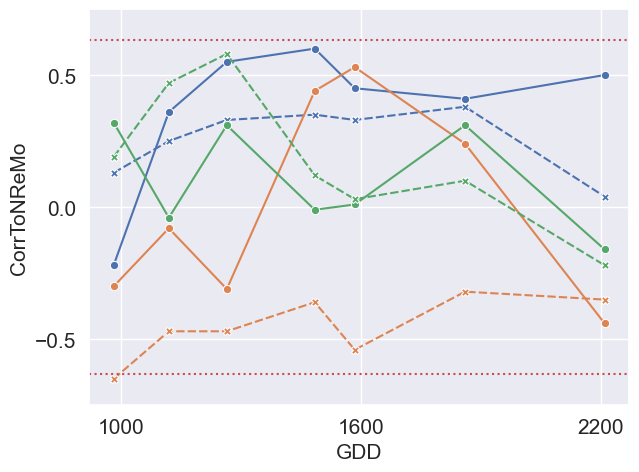

In [10]:
# Create a line graph of the corr of PCT90, STD, and ndvi with yield over time
tps = [982, 1120, 1265, 1485, 1585, 1861, 2210]
df = pd.DataFrame()
for tp in tps:
    print(tp)
    df_tp = df_npcr[df_npcr['GDD'] == tp]
    corr_tp_H = df_tp.loc[df_tp['NTreatment'] == 'H', ['NReMo', 'PCT90','STD', 'ndvi']]
    corr_tp_H = corr_tp_H.corr('spearman').round(2)
    corr_tp_H = corr_tp_H.iloc[[0],:]
    corr_tp_H['GDD'] = tp
    corr_tp_H['NTreatment'] = 'H'
    corr_tp_L = df_tp.loc[df_tp['NTreatment'] == 'L', ['NReMo', 'PCT90','STD', 'ndvi']]
    corr_tp_L = corr_tp_L.corr('spearman').round(2)
    corr_tp_L = corr_tp_L.iloc[[0],:]
    corr_tp_L['GDD'] = tp
    corr_tp_L['NTreatment'] = 'L'
    df = pd.concat([df, corr_tp_H])
    df = pd.concat([df, corr_tp_L])

# clean df
df = df.iloc[:, 1:]
df = pd.melt(df, id_vars=['GDD', 'NTreatment'], value_vars=['PCT90', 'ndvi', 'STD'], var_name='Trait', value_name='CorrToNReMo')

# make plot with new corr df over time
sns.lineplot(data = df, x = 'GDD', y='CorrToNReMo', hue = 'Trait', style='NTreatment', markers=True)
# critical value for 10 -2 = 8 df = 0.632 and alpha 0.05
plt.axhline(0.632, color = 'r', linestyle = ':')
plt.axhline(-0.632, color = 'r', linestyle = ':')
plt.ylim([-0.75, 0.75])
plt.tight_layout()
plt.xticks([1000, 1600, 2200], fontsize =15)
plt.xlabel('GDD', fontsize =15)
plt.yticks([-0.5, 0, 0.5], fontsize = 15)
plt.ylabel('CorrToNReMo', fontsize=15)
plt.legend(fontsize=12, loc='lower center', ncol=5)
plt.legend().set_visible(False)
#plt.savefig('CorrToNRemob_Ground.pdf')


# Part 2: Using RS phenotypes to probe Leaf ReMo 
* ANOVA of yield, grain N, leaf N, ReMo
* Line graph of Leaf N to illustrate ReMo
* 5 Hybrids, growth, ndvi, std line graphs

In [11]:
print(pg.anova(data = df_5hyb_li[df_5hyb_li['GDD'] == 2210], dv = 'Yield', between=['Hybrid', 'NTreatment'], ss_type=3).round(3))
print(pg.anova(data = df_5hyb_li[df_5hyb_li['GDD'] == 2210], dv = 'GrainN', between=['Hybrid', 'NTreatment'], ss_type=3).round(3))
print(pg.anova(data = df_5hyb_li[df_5hyb_li['GDD'] == 2210], dv = 'NReMo', between=['Hybrid', 'NTreatment'], ss_type=3).round(3))
print(pg.anova(data = df_5hyb_li[df_5hyb_li['GDD'] == 1585], dv = 'LeafN', between=['Hybrid', 'NTreatment'], ss_type=3).round(3))
print(pg.anova(data = df_5hyb_li[df_5hyb_li['GDD'] == 1861], dv = 'LeafN', between=['Hybrid', 'NTreatment'], ss_type=3).round(3))
print(pg.anova(data = df_5hyb_li[df_5hyb_li['GDD'] == 2210], dv = 'ndvi', between=['Hybrid', 'NTreatment'], ss_type=3).round(3))


                Source         SS  DF         MS       F  p-unc    np2
0               Hybrid   4233.422   4   1058.356   3.722  0.042  0.598
1           NTreatment  19136.362   1  19136.362  67.306  0.000  0.871
2  Hybrid * NTreatment   4492.131   4   1123.033   3.950  0.036  0.612
3             Residual   2843.200  10    284.320     NaN    NaN    NaN
                Source     SS  DF     MS        F  p-unc    np2
0               Hybrid  0.150   4  0.038    9.139  0.002  0.785
1           NTreatment  0.586   1  0.586  142.629  0.000  0.934
2  Hybrid * NTreatment  0.010   4  0.002    0.582  0.683  0.189
3             Residual  0.041  10  0.004      NaN    NaN    NaN
                Source       SS  DF       MS      F  p-unc    np2
0               Hybrid  439.138   4  109.785  3.260  0.059  0.566
1           NTreatment  192.098   1  192.098  5.704  0.038  0.363
2  Hybrid * NTreatment   81.676   4   20.419  0.606  0.667  0.195
3             Residual  336.767  10   33.677    NaN    NaN   

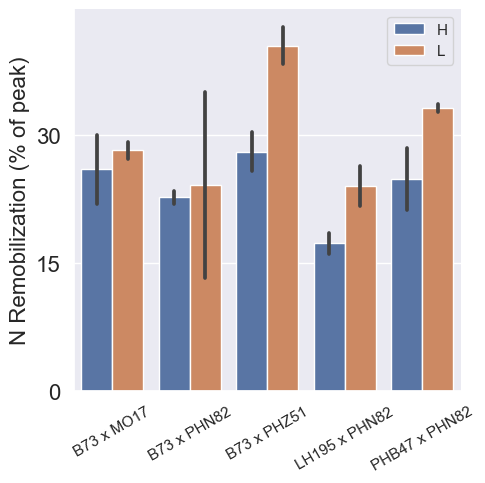

In [9]:
# graph to illustrate how to calc N ReMo
sns.catplot(data=df_5hyb_li[df_5hyb_li['GDD'] == 1265], x = 'Hybrid', y ='NReMo', hue = 'NTreatment', kind = 'bar', legend=False)
plt.ylabel('N Remobilization (% of peak)', fontsize = 16)
plt.yticks([0, 15, 30], fontsize = 16)
plt.xlabel('')
plt.xticks(rotation = 30, fontsize=11)
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('N_ReMo.pdf')

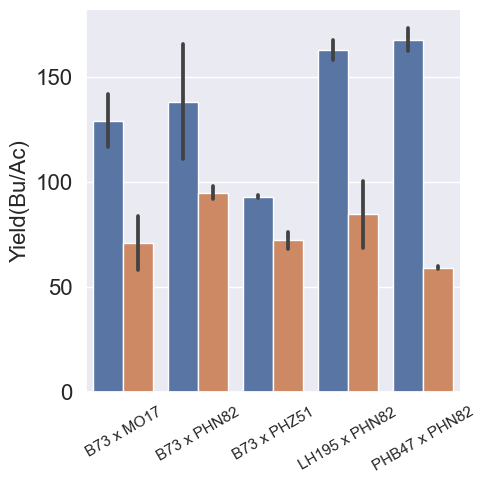

In [10]:
# graph to illustrate how to calc N ReMo
sns.catplot(data=df_5hyb_li[df_5hyb_li['GDD'] == 1265], x = 'Hybrid', y ='Yield', hue = 'NTreatment', kind = 'bar', legend=False)
plt.ylabel('Yield(Bu/Ac)', fontsize = 16)
plt.yticks([0, 50, 100, 150], fontsize = 16)
plt.xlabel('')
plt.xticks(rotation = 30, fontsize=11)
plt.tight_layout()
#plt.savefig('Yield_5Hyb.pdf')

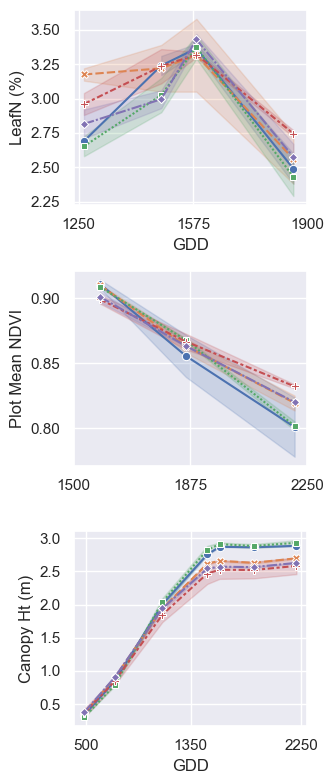

In [11]:
df_tp_li = df_5hyb_li[df_5hyb_li['NTreatment'] == 'H']
df_tp_pc = df_5hyb_pc[df_5hyb_pc['NTreatment'] == 'H']

fig, ax = plt.subplots(3, figsize = (3.5,8))
sns.lineplot(ax = ax[0], data = df_tp_li[df_tp_li['GDD'] > 1100], x = 'GDD', y = 'LeafN', hue = 'Hybrid', style = 'Hybrid', markers=True, legend=False)
ax[0].set_ylabel('LeafN (%)')
ax[0].set_xticks([1250, 1575, 1900])
sns.lineplot(ax = ax[1], data = df_tp_li[df_tp_li['GDD'] > 1500], x = 'GDD', y ='ndvi', hue = 'Hybrid',  style = 'Hybrid', markers=True, legend = False)
ax[1].set_xlabel(None)
ax[1].set_xticks([1500, 1875, 2250])
ax[1].set_ylabel('Plot Mean NDVI')
sns.lineplot(ax = ax[2], data = df_tp_li[df_tp_li['GDD'] > 450], x = 'GDD', y ='PCT90', hue = 'Hybrid',  style = 'Hybrid', markers=True, legend=False)
ax[2].set_ylabel('Canopy Ht (m)')
ax[2].set_xticks([500, 1350, 2250])
plt.tight_layout()
#plt.savefig('NresponsivePanel.pdf')

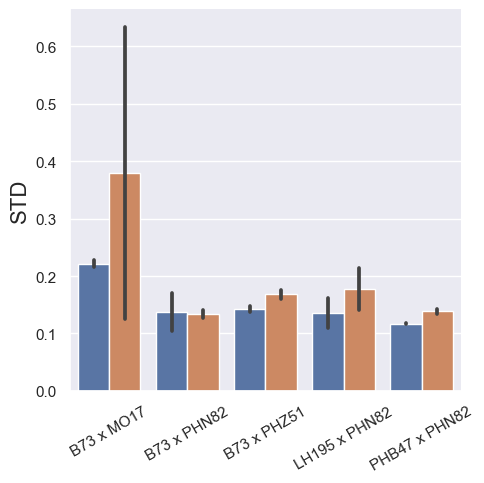

In [18]:
# graph to illustrate how to calc N ReMo
sns.catplot(data=df_5hyb_pc[df_5hyb_pc['GDD'] == 1861], x = 'Hybrid', y ='STD', hue = 'NTreatment', kind = 'bar', legend=False)
plt.ylabel('STD', fontsize = 16)
plt.xlabel('')
plt.xticks(rotation = 30, fontsize=11)
plt.tight_layout()
#plt.savefig('Yield_5Hyb.pdf')

In [17]:
# ANOVA to annotate above plot of STD dev
tps = list(df_5hyb_pc['GDD'].value_counts().keys())
for tp in tps:
    print(tp)
    df_tp = df_5hyb_pc[(df_5hyb_pc['GDD'] == tp) & (df_5hyb_pc['NTreatment'] == 'H')]
    try:
        an1 = pg.anova(data = df_tp, dv = 'STD', between = ['Hybrid'])
        print(an1)
    except: 
        print('Failed ANOVA')
        continue

1120
   Source  ddof1  ddof2         F   p-unc       np2
0  Hybrid      4      5  3.158327  0.1195  0.716446
1265
   Source  ddof1  ddof2         F     p-unc       np2
0  Hybrid      4      5  2.284208  0.194602  0.646314
1485
   Source  ddof1  ddof2         F     p-unc       np2
0  Hybrid      4      5  0.566567  0.699035  0.311889
1585
   Source  ddof1  ddof2         F     p-unc       np2
0  Hybrid      4      5  1.103627  0.446522  0.468905
1861
   Source  ddof1  ddof2         F     p-unc       np2
0  Hybrid      4      5  4.576368  0.063184  0.785458
2210
   Source  ddof1  ddof2         F     p-unc       np2
0  Hybrid      4      5  2.174355  0.208303  0.634968
285
   Source  ddof1  ddof2
0  Hybrid     -1      0
483
   Source  ddof1  ddof2
0  Hybrid     -1      0
731
   Source  ddof1  ddof2         F     p-unc       np2
0  Hybrid      4      5  0.702267  0.623045  0.359719
982
   Source  ddof1  ddof2         F     p-unc       np2
0  Hybrid      4      5  0.411932  0.794631  0.24786

c:\Users\bdub\AppData\Local\Programs\Python\Python311\Lib\site-packages\pingouin\parametric.py:1005: RuntimeWarning: invalid value encountered in scalar divide
  mserror = sserror / ddof2
c:\Users\bdub\AppData\Local\Programs\Python\Python311\Lib\site-packages\pingouin\parametric.py:1012: RuntimeWarning: invalid value encountered in scalar divide
  np2 = ssbetween / (ssbetween + sserror)  # = ssbetween / sstotal
c:\Users\bdub\AppData\Local\Programs\Python\Python311\Lib\site-packages\pingouin\parametric.py:1005: RuntimeWarning: invalid value encountered in scalar divide
  mserror = sserror / ddof2
c:\Users\bdub\AppData\Local\Programs\Python\Python311\Lib\site-packages\pingouin\parametric.py:1012: RuntimeWarning: invalid value encountered in scalar divide
  np2 = ssbetween / (ssbetween + sserror)  # = ssbetween / sstotal
c:\Users\bdub\AppData\Local\Programs\Python\Python311\Lib\site-packages\pingouin\parametric.py:1005: RuntimeWarning: invalid value encountered in scalar divide
  mserror 